<a href="https://colab.research.google.com/github/NILEG/TensorFlow/blob/main/Forecasting_with_single_layer_neural_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

####Generating Synthetic Data

In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    """
    Visualizes time series data

    Args:
      time (array of int) - contains the time steps
      series (array of int) - contains the measurements for each time step
      format - line style when plotting the graph
      label - tag for the line
      start - first time step to plot
      end - last time step to plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))

    if type(series) is tuple:

      for series_num in series:
        # Plot the time series data
        plt.plot(time[start:end], series_num[start:end], format)

    else:
      # Plot the time series data
      plt.plot(time[start:end], series[start:end], format)

    # Label the x-axis
    plt.xlabel("Time")

    # Label the y-axis
    plt.ylabel("Value")

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()


def trend(time, slope=0):
    """
    Generates synthetic data that follows a straight line given a slope value.

    Args:
      time (array of int) - contains the time steps
      slope (float) - determines the direction and steepness of the line

    Returns:
      series (array of float) - measurements that follow a straight line
    """

    # Compute the linear series given the slope
    series = slope * time

    return series


def seasonal_pattern(season_time):
    """
    Just an arbitrary pattern, you can change it if you wish

    Args:
      season_time (array of float) - contains the measurements per time step

    Returns:
      data_pattern (array of float) -  contains revised measurement values according
                                  to the defined pattern
    """

    # Generate the values using an arbitrary pattern
    data_pattern = np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

    return data_pattern


def seasonality(time, period, amplitude=1, phase=0):
    """
    Repeats the same pattern at each period

    Args:
      time (array of int) - contains the time steps
      period (int) - number of time steps before the pattern repeats
      amplitude (int) - peak measured value in a period
      phase (int) - number of time steps to shift the measured values

    Returns:
      data_pattern (array of float) - seasonal data scaled by the defined amplitude
    """

    # Define the measured values per period
    season_time = ((time + phase) % period) / period

    # Generates the seasonal data scaled by the defined amplitude
    data_pattern = amplitude * seasonal_pattern(season_time)

    return data_pattern


def noise(time, noise_level=1, seed=None):
    """Generates a normally distributed noisy signal

    Args:
      time (array of int) - contains the time steps
      noise_level (float) - scaling factor for the generated signal
      seed (int) - number generator seed for repeatability

    Returns:
      noise (array of float) - the noisy signal
    """

    # Initialize the random number generator
    rnd = np.random.RandomState(seed)

    # Generate a random number for each time step and scale by the noise level
    noise = rnd.randn(len(time)) * noise_level

    return noise

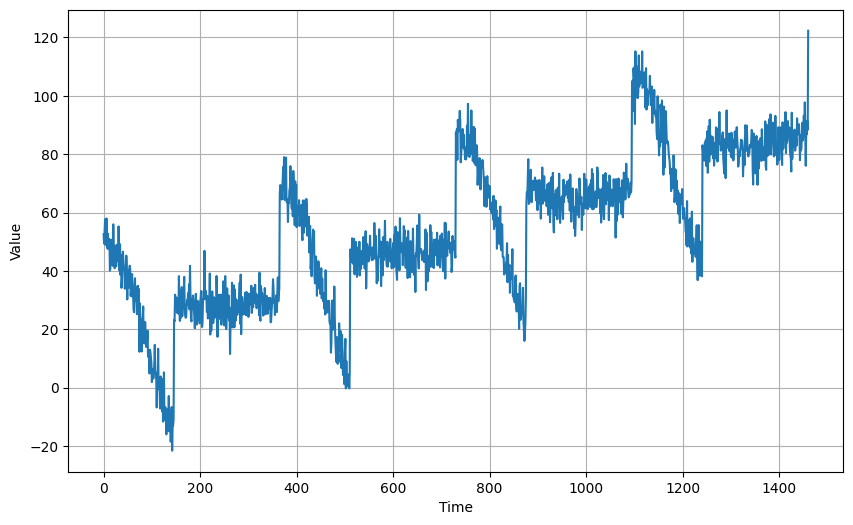

In [3]:
# Parameters
time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

# Update with noise
series += noise(time, noise_level, seed=42)

# Plot the results
plot_series(time, series)

####Splitting Data

In [4]:
SPLIT_SIZE=1000
#Training
x_train=series[:SPLIT_SIZE]
train_time=time[:SPLIT_SIZE]

#Testing
x_test=series[SPLIT_SIZE:]
test_time=time[SPLIT_SIZE:]

####Windowing Function

In [5]:
def windowed_funct(series, window_size, batch, buffer):
  #Converting series into tensors
  dataset=tf.data.Dataset.from_tensor_slices(series)
  #print(list(dataset.as_numpy_iterator()))
  dataset=dataset.window(window_size+1, shift=1, drop_remainder=True)
  dataset=dataset.flat_map(lambda x: x.batch(window_size+1))
  dataset=dataset.map(lambda x:(x[:-1], x[-1]))
  dataset= dataset.shuffle(buffer)
  dataset= dataset.batch(batch).prefetch(1)
  return dataset
dataset=windowed_funct(np.arange(10), 5,2,10)
print(list(dataset.as_numpy_iterator()))

[(array([[4, 5, 6, 7, 8],
       [1, 2, 3, 4, 5]]), array([9, 6])), (array([[3, 4, 5, 6, 7],
       [2, 3, 4, 5, 6]]), array([8, 7])), (array([[0, 1, 2, 3, 4]]), array([5]))]


In [6]:
# Parameters
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

dataset=windowed_funct(x_train, window_size, batch_size, shuffle_buffer_size)

####Creating Model

In [7]:
model=tf.keras.Sequential([tf.keras.layers.Input(shape=(window_size, )),
                           tf.keras.layers.Dense(units=1)])

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9), metrics=["mae"])
history=model.fit(dataset, epochs=100, verbose=0)

In [8]:
weights=model.layers[0].get_weights()
print(weights)
#Here 20-> for W & 1=> biasness(B)

[array([[ 0.02407412],
       [-0.04557065],
       [-0.03251675],
       [ 0.03934849],
       [-0.00562986],
       [ 0.03257534],
       [-0.00931219],
       [-0.00339636],
       [-0.01424016],
       [ 0.01615107],
       [ 0.02161872],
       [ 0.02798175],
       [-0.09358874],
       [ 0.05362202],
       [-0.02305022],
       [ 0.04676187],
       [ 0.06617373],
       [ 0.2409492 ],
       [ 0.18130773],
       [ 0.46977058]], dtype=float32), array([0.01620278], dtype=float32)]


####Prediction

In [ ]:
forecast=[]
for time in range(len(series)-window_size):
  forecast.append(model.predict(np.expand_dims(series[time: time+window_size], axis=0)))



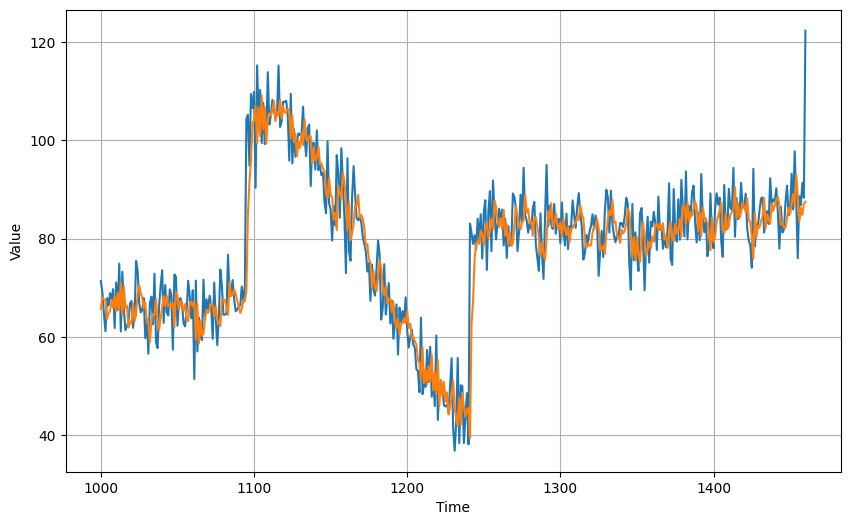

In [18]:
test_pred=forecast[SPLIT_SIZE-window_size:]
test_pred=np.array(test_pred)
test_pred=test_pred.squeeze()
plot_series(test_time, (series[SPLIT_SIZE: ], test_pred))